# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

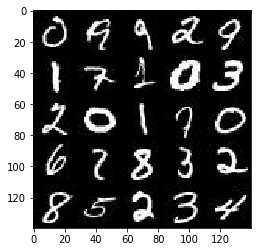

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

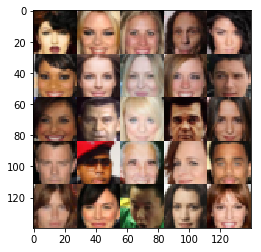

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #for leaky ReLU (paper)
    alpha = 0.2
    
    with tf.variable_scope( 'discriminator', reuse=reuse ):
        #Input layer 28x28x(1|3)
        x1 = tf.layers.conv2d( images, 128, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum( alpha*x1, x1 )
        #14x14x128      
        
        x2 = tf.layers.conv2d( x1, 256, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=True )
        x2 = tf.maximum( alpha*x2, x2 )
        #7x7x256
        
        x3 = tf.layers.conv2d( x2, 512, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization( x3, training=True )
        x3 = tf.maximum( alpha*x3, x3 )
        #4x4x514
        
        #Flatten vector
        flat = tf.reshape( x3, (-1, 4*4*512) )
        logits = tf.layers.dense( flat, 1 )
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    #kernel_initializer=tf.contrib.layers.xavier_initializer()
    
    #for leaky ReLU
    #alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        #Fully connected
        x1 = tf.layers.dense(z, 7*7*512)
        
        '''
        x1 = tf.reshape( x1, (-1, 4, 4, 512) )
        x1 = tf.layers.batch_normalization( x1, training=is_train )
        x1 = tf.nn.relu(x1)
        #x1 = tf.maximum( alpha*x1, x1 )        
        #4x4x512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=is_train )
        x2 = tf.nn.relu(x2)
        #x2 = tf.maximum( alpha*x2, x2 )
        #7x7x256
        '''
        
        #Reshape to 7x7x512
        x1 = tf.reshape( x1, (-1, 7, 7, 512) )
        x1 = tf.layers.batch_normalization( x1, training=is_train )
        x1 = tf.nn.relu(x1)
        #x1 = tf.maximum( alpha*x1, x1 )        
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides=2, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=is_train )
        x2 = tf.nn.relu(x2)
        #x2 = tf.maximum( alpha*x2, x2 )
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose( x2, 128, 5, strides=2, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        x3 = tf.nn.relu(x3)
        #x3 = tf.maximum( alpha*x3, x3 )
        #28x28x128       

        logits = tf.layers.conv2d_transpose( x3, out_channel_dim, 5, strides=1, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        #28x28xout_channel_dim
        
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # For label smoothing
    smooth = 0.1
    
    g_model = generator( input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real )
    d_model_fake, d_logits_fake = discriminator( g_model, reuse=True )
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth) ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Weights and bias
    t_vars = tf.trainable_variables()
    d_vars = [ var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [ var for var in t_vars if var.name.startswith('generator') ]
    
    # Optimization
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS ) ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images = 25
    print_every = 40
    show_every = 400
       
    sample_z = tf.constant(np.random.uniform(-1, 1, size=(n_images,z_dim)), dtype=tf.float32)
    steps = 0
    
    n_examples, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_input, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # generator input z
                batch_z = np.random.uniform( -1, 1, size=(batch_size, z_dim))
                #batch_z2 = np.random.uniform( -1, 1, size=(batch_size, z_dim))
                
                # optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real:batch_images, learning_rate_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real:batch_images, learning_rate_input:learning_rate})
                
                if steps % print_every == 0:
                    #print losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}, Epoch {}/{}...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))  
                 
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, sample_z, image_channels, data_image_mode)      
        
        print("Final examples")
        show_generator_output(sess, n_images, sample_z, image_channels, data_image_mode)   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 40, Epoch 1/2... Discriminator Loss: 2.0479... Generator Loss: 0.4956
Step 80, Epoch 1/2... Discriminator Loss: 3.4246... Generator Loss: 0.0979
Step 120, Epoch 1/2... Discriminator Loss: 1.8244... Generator Loss: 0.4080
Step 160, Epoch 1/2... Discriminator Loss: 1.8356... Generator Loss: 0.3712
Step 200, Epoch 1/2... Discriminator Loss: 1.6949... Generator Loss: 0.6157
Step 240, Epoch 1/2... Discriminator Loss: 1.7656... Generator Loss: 0.6832
Step 280, Epoch 1/2... Discriminator Loss: 1.6797... Generator Loss: 1.1670
Step 320, Epoch 1/2... Discriminator Loss: 1.6466... Generator Loss: 0.5258
Step 360, Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.3564
Step 400, Epoch 1/2... Discriminator Loss: 1.7825... Generator Loss: 0.3815


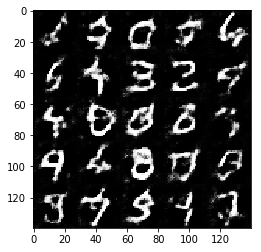

Step 440, Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.6486
Step 480, Epoch 1/2... Discriminator Loss: 1.5962... Generator Loss: 0.5082
Step 520, Epoch 1/2... Discriminator Loss: 1.8551... Generator Loss: 0.5979
Step 560, Epoch 1/2... Discriminator Loss: 1.7517... Generator Loss: 0.3757
Step 600, Epoch 1/2... Discriminator Loss: 1.7985... Generator Loss: 0.3401
Step 640, Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.4982
Step 680, Epoch 1/2... Discriminator Loss: 1.7622... Generator Loss: 0.3429
Step 720, Epoch 1/2... Discriminator Loss: 1.9301... Generator Loss: 0.2921
Step 760, Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.7854
Step 800, Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.5470


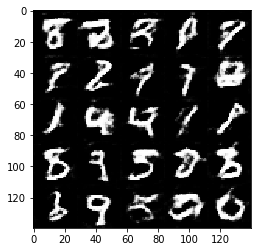

Step 840, Epoch 1/2... Discriminator Loss: 1.8468... Generator Loss: 0.2978
Step 880, Epoch 1/2... Discriminator Loss: 2.1345... Generator Loss: 0.2170
Step 920, Epoch 1/2... Discriminator Loss: 1.6637... Generator Loss: 0.3674
Step 960, Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.5938
Step 1000, Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.7870
Step 1040, Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.4211
Step 1080, Epoch 1/2... Discriminator Loss: 1.9182... Generator Loss: 0.2718
Step 1120, Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 1.2046
Step 1160, Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.6986
Step 1200, Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.3984


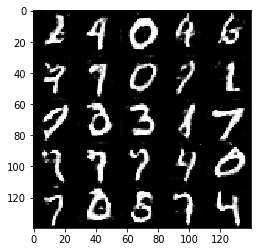

Step 1240, Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.6499
Step 1280, Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.7239
Step 1320, Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.5189
Step 1360, Epoch 1/2... Discriminator Loss: 1.9414... Generator Loss: 0.2508
Step 1400, Epoch 1/2... Discriminator Loss: 1.5857... Generator Loss: 0.4272
Step 1440, Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 0.4512
Step 1480, Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 0.5228
Step 1520, Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.4406
Step 1560, Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 1.2333
Step 1600, Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 1.0196


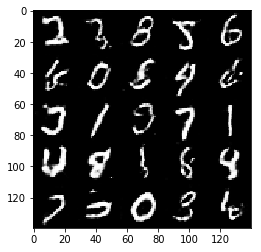

Step 1640, Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 0.3744
Step 1680, Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.5190
Step 1720, Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.9295
Step 1760, Epoch 1/2... Discriminator Loss: 1.5246... Generator Loss: 0.5955
Step 1800, Epoch 1/2... Discriminator Loss: 1.5816... Generator Loss: 0.5594
Step 1840, Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.9693
Step 1880, Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 0.4479
Step 1920, Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.7786
Step 1960, Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.7138
Step 2000, Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4118


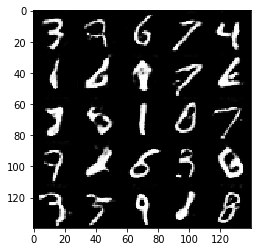

Step 2040, Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.7804
Step 2080, Epoch 2/2... Discriminator Loss: 1.6959... Generator Loss: 0.4034
Step 2120, Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 0.5429
Step 2160, Epoch 2/2... Discriminator Loss: 1.6036... Generator Loss: 0.3832
Step 2200, Epoch 2/2... Discriminator Loss: 1.5680... Generator Loss: 0.4216
Step 2240, Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.6864
Step 2280, Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 0.5144
Step 2320, Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.7461
Step 2360, Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.8408
Step 2400, Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.5366


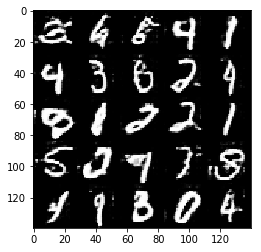

Step 2440, Epoch 2/2... Discriminator Loss: 1.5722... Generator Loss: 0.4415
Step 2480, Epoch 2/2... Discriminator Loss: 1.5973... Generator Loss: 0.4120
Step 2520, Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.9840
Step 2560, Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.0111
Step 2600, Epoch 2/2... Discriminator Loss: 1.6148... Generator Loss: 0.4039
Step 2640, Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.8450
Step 2680, Epoch 2/2... Discriminator Loss: 1.8674... Generator Loss: 0.2882
Step 2720, Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.9863
Step 2760, Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 1.2581
Step 2800, Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.5292


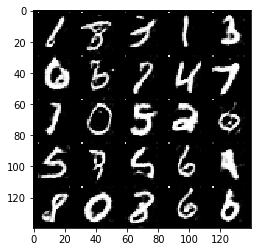

Step 2840, Epoch 2/2... Discriminator Loss: 1.7687... Generator Loss: 0.3783
Step 2880, Epoch 2/2... Discriminator Loss: 1.7097... Generator Loss: 0.4265
Step 2920, Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.5936
Step 2960, Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.6058
Step 3000, Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.5061
Step 3040, Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.7179
Step 3080, Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.0335
Step 3120, Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 1.0725
Step 3160, Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 0.7001
Step 3200, Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.7025


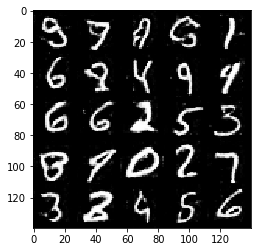

Step 3240, Epoch 2/2... Discriminator Loss: 1.9128... Generator Loss: 0.2803
Step 3280, Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.4196
Step 3320, Epoch 2/2... Discriminator Loss: 1.6719... Generator Loss: 0.3665
Step 3360, Epoch 2/2... Discriminator Loss: 2.2328... Generator Loss: 0.2340
Step 3400, Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 1.3963
Step 3440, Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.7736
Step 3480, Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.7366
Step 3520, Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.4279
Step 3560, Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.8817
Step 3600, Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 0.4610


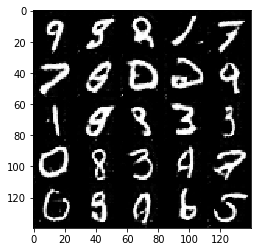

Step 3640, Epoch 2/2... Discriminator Loss: 1.7363... Generator Loss: 0.3596
Step 3680, Epoch 2/2... Discriminator Loss: 1.6496... Generator Loss: 0.4364
Step 3720, Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.5051
Final examples


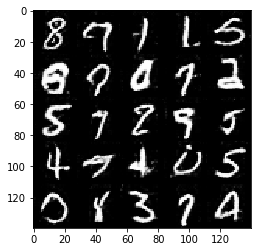

In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 40, Epoch 1/1... Discriminator Loss: 2.3331... Generator Loss: 1.4127
Step 80, Epoch 1/1... Discriminator Loss: 2.1696... Generator Loss: 0.3464
Step 120, Epoch 1/1... Discriminator Loss: 2.0712... Generator Loss: 0.2436
Step 160, Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.3993
Step 200, Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 1.2163
Step 240, Epoch 1/1... Discriminator Loss: 1.8587... Generator Loss: 0.4122
Step 280, Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.3685
Step 320, Epoch 1/1... Discriminator Loss: 1.9540... Generator Loss: 0.3034
Step 360, Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.1131
Step 400, Epoch 1/1... Discriminator Loss: 1.9371... Generator Loss: 0.3479


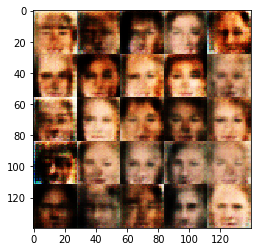

Step 440, Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 1.0738
Step 480, Epoch 1/1... Discriminator Loss: 2.0047... Generator Loss: 0.2672
Step 520, Epoch 1/1... Discriminator Loss: 1.8664... Generator Loss: 0.3380
Step 560, Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 1.0404
Step 600, Epoch 1/1... Discriminator Loss: 1.9374... Generator Loss: 0.2898
Step 640, Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8488
Step 680, Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.4734
Step 720, Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8422
Step 760, Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.8095
Step 800, Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5917


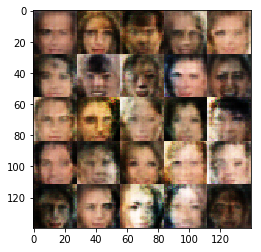

Step 840, Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6638
Step 880, Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.5772
Step 920, Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7414
Step 960, Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.6297
Step 1000, Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7048
Step 1040, Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.5912
Step 1080, Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6367
Step 1120, Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.6382
Step 1160, Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7459
Step 1200, Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6956


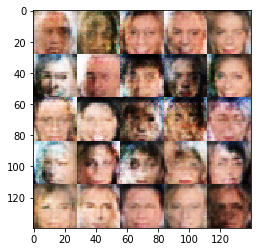

Step 1240, Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.7091
Step 1280, Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6982
Step 1320, Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6805
Step 1360, Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7583
Step 1400, Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7993
Step 1440, Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.6552
Step 1480, Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6727
Step 1520, Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7783
Step 1560, Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7400
Step 1600, Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7497


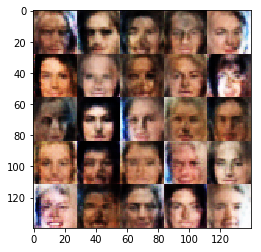

Step 1640, Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7173
Step 1680, Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6673
Step 1720, Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.6867
Step 1760, Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7329
Step 1800, Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6544
Step 1840, Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6958
Step 1880, Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.6456
Step 1920, Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7111
Step 1960, Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.8410
Step 2000, Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6432


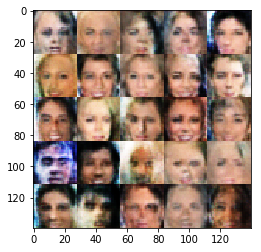

Step 2040, Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6136
Step 2080, Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7682
Step 2120, Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6991
Step 2160, Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7036
Step 2200, Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6628
Step 2240, Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6856
Step 2280, Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7426
Step 2320, Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7232
Step 2360, Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6647
Step 2400, Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8551


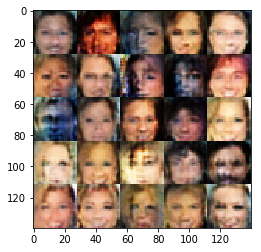

Step 2440, Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6601
Step 2480, Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.5511
Step 2520, Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.7372
Step 2560, Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6872
Step 2600, Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6561
Step 2640, Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8267
Step 2680, Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6655
Step 2720, Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6090
Step 2760, Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6751
Step 2800, Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.7495


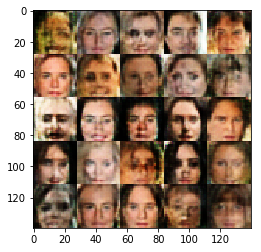

Step 2840, Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6785
Step 2880, Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7106
Step 2920, Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6354
Step 2960, Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8266
Step 3000, Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7216
Step 3040, Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6643
Step 3080, Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7586
Step 3120, Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6739
Step 3160, Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.7017
Step 3200, Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.7225


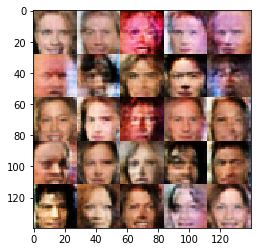

Step 3240, Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7188
Step 3280, Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7767
Step 3320, Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6932
Step 3360, Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7577
Step 3400, Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6320
Step 3440, Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6422
Step 3480, Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7440
Step 3520, Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.7417
Step 3560, Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.7522
Step 3600, Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6772


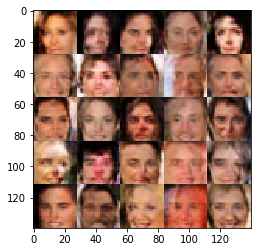

Step 3640, Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7924
Step 3680, Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6693
Step 3720, Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7859
Step 3760, Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7182
Step 3800, Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7400
Step 3840, Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7998
Step 3880, Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7501
Step 3920, Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7145
Step 3960, Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7836
Step 4000, Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6754


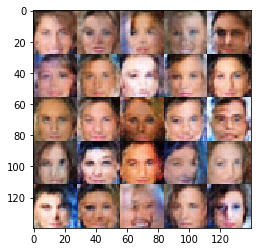

Step 4040, Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6943
Step 4080, Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7835
Step 4120, Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6440
Step 4160, Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5751
Step 4200, Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7076
Step 4240, Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7685
Step 4280, Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7284
Step 4320, Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7615
Step 4360, Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6703
Step 4400, Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7335


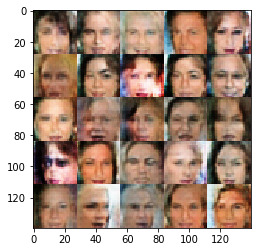

Step 4440, Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6409
Step 4480, Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6443
Step 4520, Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6435
Step 4560, Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7238
Step 4600, Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.6368
Step 4640, Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6866
Step 4680, Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7389
Step 4720, Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7616
Step 4760, Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6625
Step 4800, Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6170


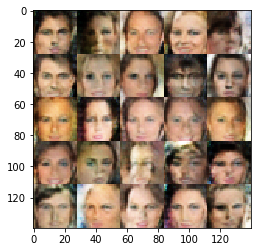

Step 4840, Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6598
Step 4880, Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6507
Step 4920, Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6069
Step 4960, Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7262
Step 5000, Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7993
Step 5040, Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7620
Step 5080, Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6978
Step 5120, Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7880
Step 5160, Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7589
Step 5200, Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7128


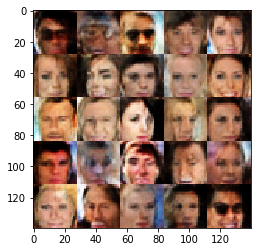

Step 5240, Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7167
Step 5280, Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6968
Step 5320, Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7175
Step 5360, Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6410
Step 5400, Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6536
Step 5440, Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7730
Step 5480, Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6489
Step 5520, Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7205
Step 5560, Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7228
Step 5600, Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6654


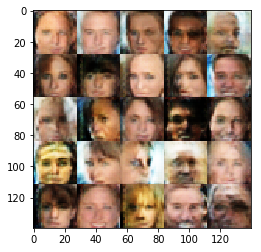

Step 5640, Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.8286
Step 5680, Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7243
Step 5720, Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7300
Step 5760, Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8284
Step 5800, Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6063
Step 5840, Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6873
Step 5880, Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7305
Step 5920, Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.8173
Step 5960, Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7141
Step 6000, Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7895


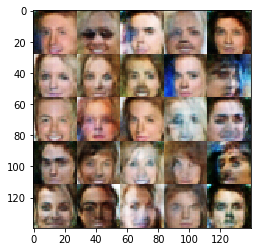

Step 6040, Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7514
Step 6080, Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.7398
Step 6120, Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7521
Step 6160, Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7212
Step 6200, Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6478
Step 6240, Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7924
Step 6280, Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.8274
Step 6320, Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6376
Final examples


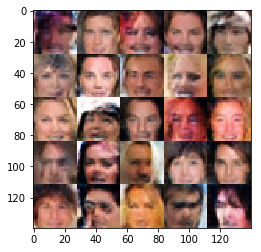

In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.